In [1]:
%load_ext autoreload
%autoreload 2

# Counterfactuals evaluation for the GSMarena dataset

We decided to evaluate the data in 2 separate sets, the correctly predicted samples by the neural network and the misclassified ones. For the ***former*** we can compute the following counterfactuals:
- from low-price to medium-price
- from medium-price to low-price and to high-price
- from high-price to medium-price.

While if a sample was misclassified by the model, we generate the counterfactual to obtain the correct class. For some samples the OMLT and the DiCE models are not able to find a valid counterfactual within the time limit.

### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [2]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


In [3]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import of the libraries

In [4]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from utils.util_base_cf import inverse_pipeline
import utils.util_evaluation as util_evaluation
from utils import util_counterfactual

In [5]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

In [6]:
cols_pipeline = pickle.load(open("config/pipeline.pkl", "rb"))

Check the number of samples that we will test.

In [7]:
df_test = pd.read_csv("data/model/gsm_test.csv", index_col=0)

df_test_den = inverse_pipeline(cols_pipeline, df_test)
df_test_den = df_test_den.astype({"num_main_camera": float})
df_test_den = util_evaluation.cast_round_type(df_test_den, df_test_den.dtypes.to_dict())
print(f"Number of samples in test set: {len(df_test_den)}")

Number of samples in test set: 383


In [8]:
# The name of the features used during training and for counterfactual generation
feature_columns = df_test_den.columns.drop(["misc_price_min", "misc_price_max"])
print(f"Feature columns: {feature_columns.tolist()}")

Feature columns: ['display_size', 'battery', 'memory_ram_gb', 'memory_rom_gb', 'main_camera_resolution', 'selfie_camera_resolution', 'display_resolution', 'network_technology', 'num_main_camera', 'has_oled_display', 'has_memory_card_slot', 'has_stereo_speakers', 'has_3.5mm_jack', 'has_wlan_5ghz', 'has_nfc', 'has_wireless_charging', 'is_waterproof']


## Evaluation on correctly predicted samples

In this section we will analyze the performance of the counterfactual generation on samples that are correctly predicted by our model.

To compute the differences from the original samples, we need to import the dataframe with test data and we have to denormalize them. In the imported dataset we have some features that are not numbers, therefore we first have to do a simple remapping (like a LabelEncoding) from strings to the number that represents that text.

We also need to import the training data to compute some statistics and proceed with our analysis.

In [9]:
df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)

# Denormalize the data and keep only necessary columns
df_train = inverse_pipeline(cols_pipeline, df_train)
df_train = df_train.astype({"num_main_camera": float})
print(f"Number of samples in training set: {len(df_train)}")

Number of samples in training set: 1521


### OMLT

Read the counterfactuals generated by Omlt on the test set.

In [10]:
tmp_1 = pd.read_csv("data/counterfactual/all_omlt.csv", index_col=0)
tmp_2 = pd.read_csv("data/counterfactual/medium_low.csv", index_col=0)
pd.concat([tmp_1, tmp_2]).to_csv("data/counterfactual/corr_cf_omlt.csv")

In [11]:
df_cf_omlt_corr = pd.read_csv("data/counterfactual/corr_cf_omlt.csv", index_col=0)
df_cf_omlt_corr = util_evaluation.cast_round_type(df_cf_omlt_corr, df_test_den.dtypes.to_dict())

In [12]:
print(f"Number of counterfactuals found by OMLT: {df_cf_omlt_corr.shape[0]}/{df_test.shape[0]}")
# df_cf_omlt_corr.head()

Number of counterfactuals found by OMLT: 377/383


At this point we merge the counterfactuals with the test dataset with an inner join and we set the features with the same value of the original sample to Nan. In this way we can quickly find all the features changed in the counterfactuals. 

In [13]:
merge_df_omlt_corr = util_evaluation.join_merge_columns(df_cf_omlt_corr, df_test_den, ["misc_price_min", "misc_price_max"])

We show the number of features changed by OMLT to generate the valid counterfactuals.

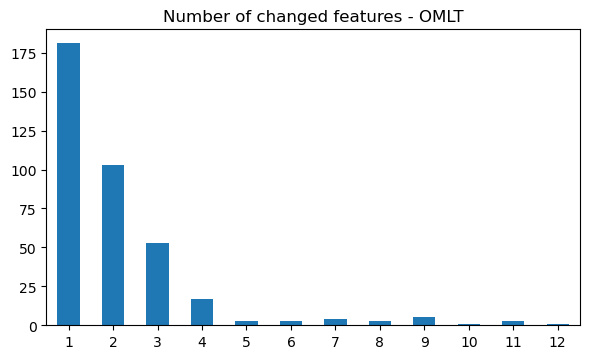

In [14]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_corr, feature_columns, plot_mode="changed_feat", 
    plot_title="Number of changed features - OMLT", split_ranges=False, figsize=(6, 3.7))

We can deduct, from the previous graph, that the average number of features changed by Omlt is around 7. 

The rare cases in which OMLT changed more than 11 features are samples for which the solver was not able to find a solution within the time limit, therefore it only cares about changing the label instead of optimizing the objective functions.

**Split the features**

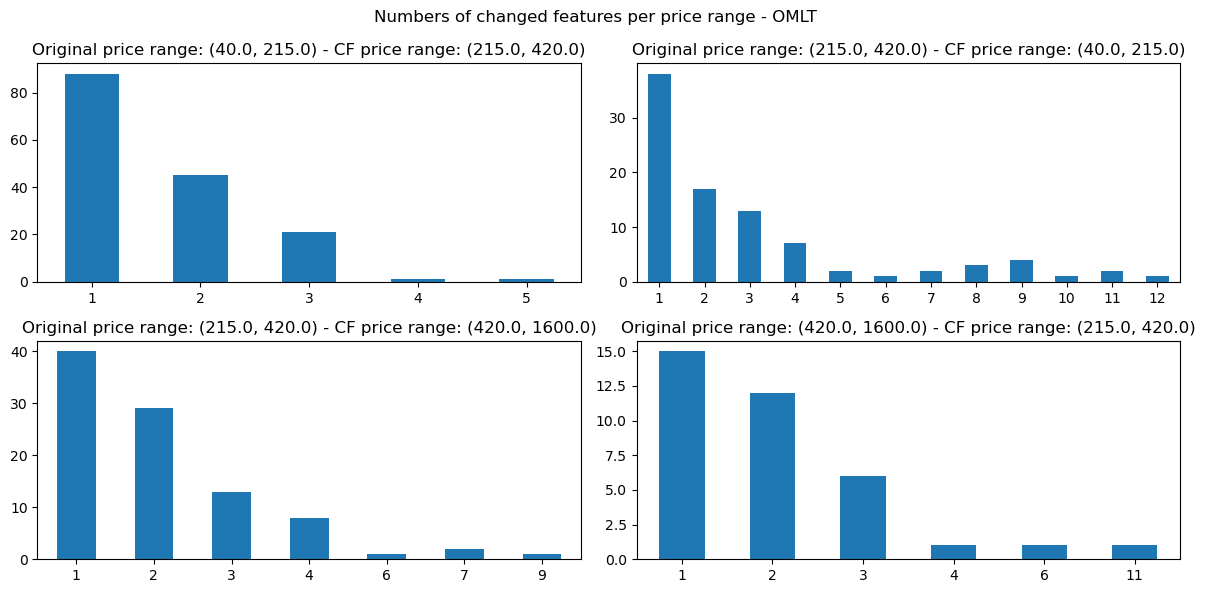

In [15]:
util_evaluation.plot_cfs_stats(merge_df_omlt_corr, feature_columns=None, plot_mode="changed_feat", 
                               split_ranges=True, plot_title="Numbers of changed features per price range - OMLT", 
                               figsize=(12,6))

As we can see from the subplots, passing from the low to the medium range seems to be the easiest change of label for Omlt, using few features. 

While it's difficult for the model to change the label from medium to low range and from medium to high range, it may require up to 16 or 17 changed features.


**Changes per feature**

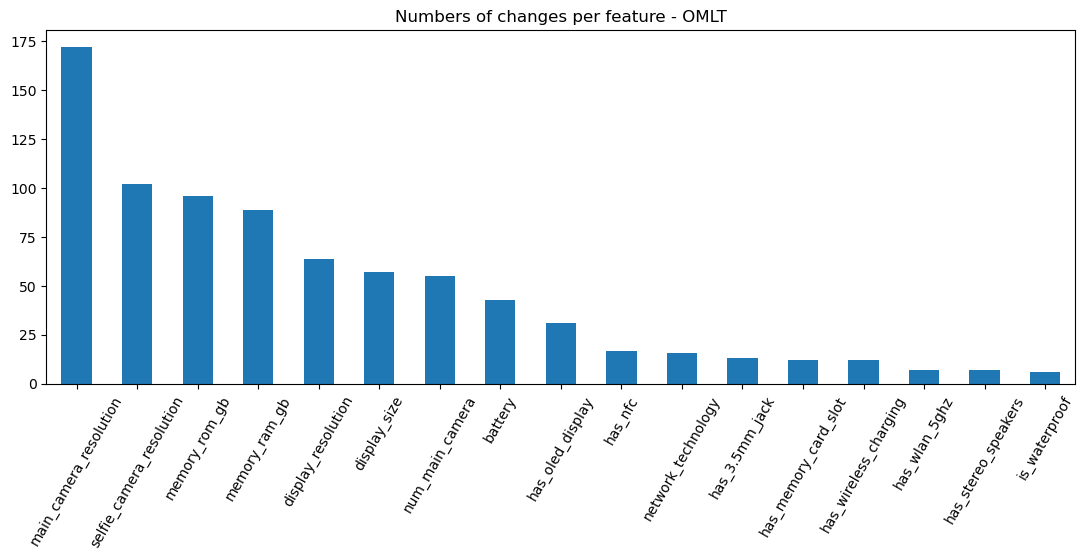

In [16]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_corr, feature_columns, plot_mode="feat_count", split_ranges=False,
    plot_title="Numbers of changes per feature - OMLT", figsize=(11, 5.7))

Another interesting chart that we can plot it's the one representing how many times each feature has been changed during the counterfactuals generation, such that we can discover which features are the most useful to change the price range of a device.

In our case the most important features seem to be ***battery***, ***memory_ram_gb***, ***display_size***, ***memory_rom_gb*** and ***main_camera_resolution***.

Also in this case we want to check if some features are more useful than others for changing the label from one price range to another.

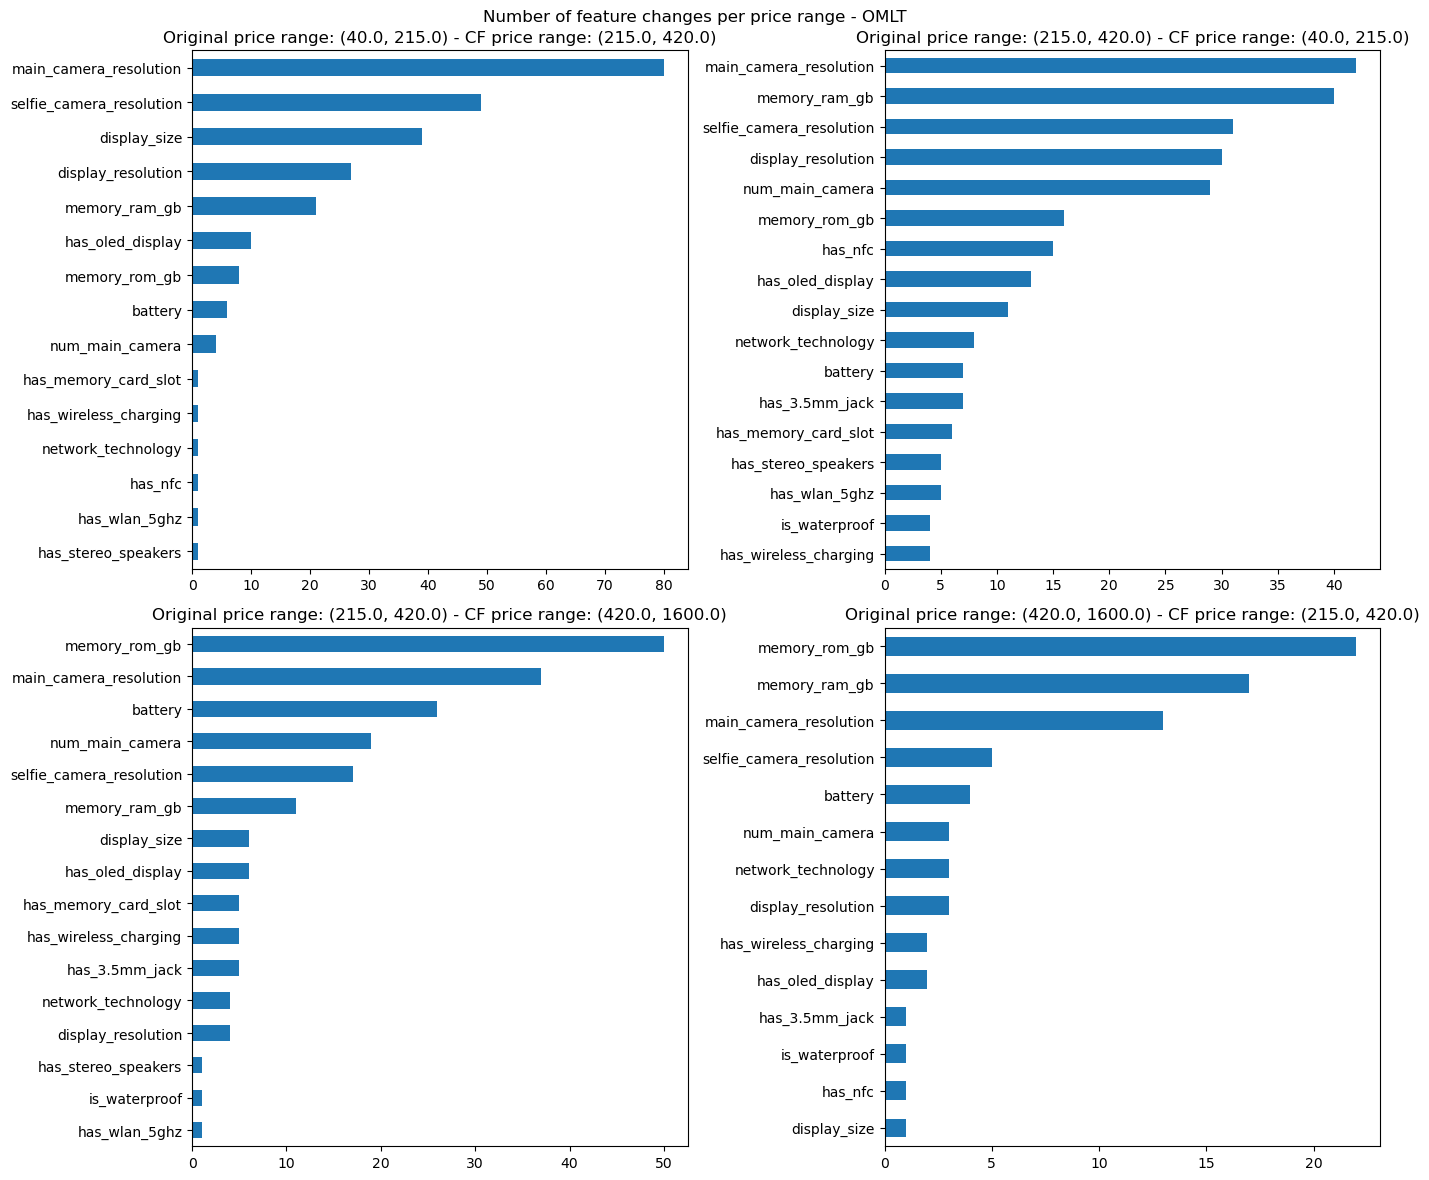

In [17]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_corr, feature_columns, plot_mode="feat_count", split_ranges=True,
    plot_title="Number of feature changes per price range - OMLT", figsize=(14, 12)
)

In [18]:
def features_changed(sample: pd.Series, ignore_cols: list, subfix: list, sep="_"):
    def get_columsn_with_subfix(columns: pd.Index, remove_subfix):
        if remove_subfix:
            columns = columns.str.rsplit(sep, n=1).str[0]
        return [f"{col}{sep}{sub}" for sub in subfix for col in columns]

    if len(subfix) < 2:
        raise ValueError("The subfix list must contain at least two elements")
    
    ignore_cols = get_columsn_with_subfix(ignore_cols, False)
    # check columns are in sample
    assert all([col in sample.index for col in ignore_cols])

    # feature columns (have subfixes)
    features_cols = sample.index.drop(ignore_cols)
    # get features which haven't changed
    nan_cols = get_columsn_with_subfix(sample[sample.isna()].index, True)
    # get features which have changed
    changed_cols = features_cols.difference(nan_cols)
    changed_cols = changed_cols.str.rsplit(sep, n=1).str[0].unique()

    for c in changed_cols:
        # first element of subfix is the relative name
        relative_dff = abs(sample[f"{c}{sep}{subfix[0]}"] - sample[f"{c}{sep}{subfix[1]}"]) / sample[f"{c}{sep}{subfix[0]}"]
        print(f"{c}: {relative_dff}")

ignore_cols = ["misc_price_min", "misc_price_max", "display_resolution", "network_technology", 
               "has_oled_display", "has_memory_card_slot", "has_stereo_speakers", "has_3.5mm_jack", 
               "has_wlan_5ghz", "has_nfc", "has_wireless_charging", "is_waterproof"]
features_changed(merge_df_omlt_corr.iloc[0], ignore_cols, ["original", "cf"])

selfie_camera_resolution: 0.5


In [48]:
merge_df_omlt_corr.iloc[0]["memory_rom_gb_cf"], merge_df_omlt_corr.iloc[0]["memory_rom_gb_original"]

(64.0, 63.999999999999986)

### Dice

In this other section we want to check how Dice generated the counterfactuals for the correctly predicted samples.

In [19]:
df_cf_dice_corr = pd.read_csv("data/counterfactual/corr_cf_dice.csv", index_col=0)
df_cf_dice_corr = util_evaluation.cast_round_type(df_cf_dice_corr, df_test_den.dtypes.to_dict())
df_cf_dice_corr.head()

,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.36,4000.0,3.0,32.0,17.0,13.0,FHD,4G,2.0,0,1,0,1,1,0,0,0
1861,40.0,215.0,5.50,3000.0,3.0,32.0,13.0,9.0,FHD,4G,1.0,0,1,0,1,1,0,0,0
1339,40.0,215.0,5.50,3340.0,1.0,32.0,17.0,13.0,FHD,4G,2.0,0,1,0,1,0,1,0,1
664,215.0,420.0,5.70,3000.0,4.0,64.0,13.0,9.0,FHD,4G,1.0,0,0,0,1,0,0,0,0
918,40.0,215.0,5.50,3000.0,3.0,32.0,13.0,9.0,FHD,4G,1.0,0,1,0,1,1,0,0,0


In [20]:
print(f"Number of counterfactuals found by DiCE: {df_cf_dice_corr.shape[0]}/{df_test.shape[0]}")

Number of counterfactuals found by DiCE: 372/383


As in the section before, we compute the merge between the test dataframe and the one that contains the counterfactuals generated by Dice.

In [21]:
merge_df_dice_corr = util_evaluation.join_merge_columns(df_cf_dice_corr, df_test_den, ["misc_price_min", "misc_price_max"])

First of all we plot a generic chart that shows the number of changed features for the generated counterfactuals.

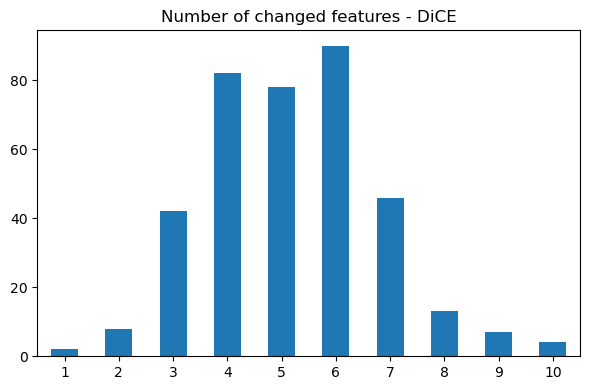

In [22]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_corr, feature_columns, plot_mode="changed_feat",
    plot_title="Number of changed features - DiCE", split_ranges=False, figsize=(6,4))

Then we check if there are some ranges that are more difficult to change.

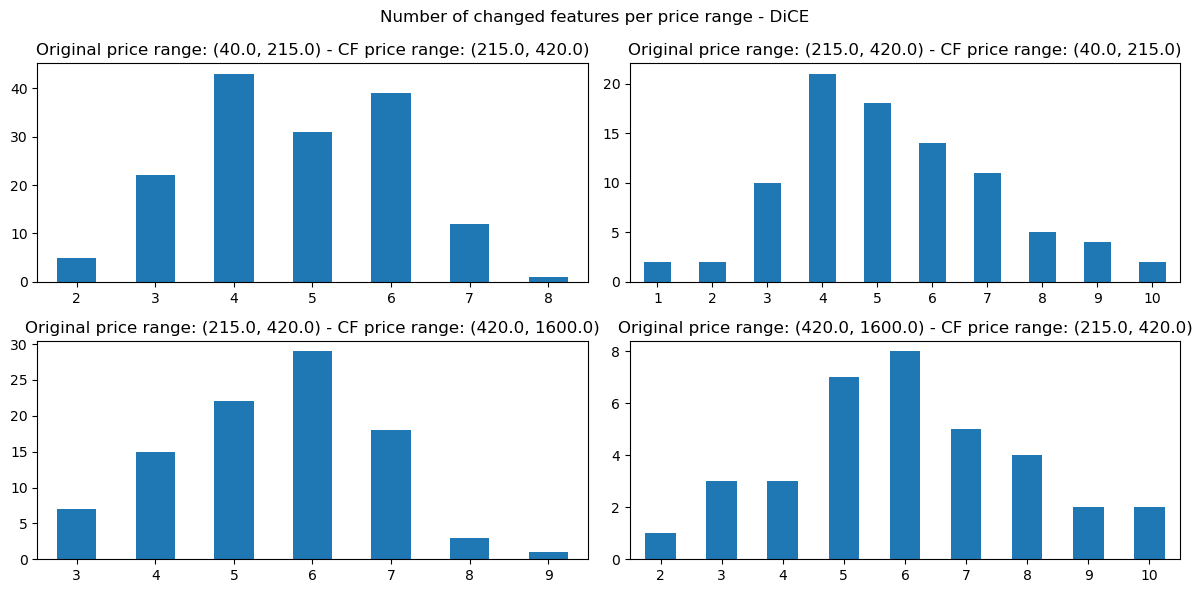

In [23]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_corr, feature_columns, plot_mode="changed_feat", split_ranges=True,
    plot_title="Number of changed features per price range - DiCE", figsize=(12, 6))

We can notice that in general Dice can generate the counterfactuals changing less features than Omlt.

As for OMLT we plot the number of changes occured for each feature.

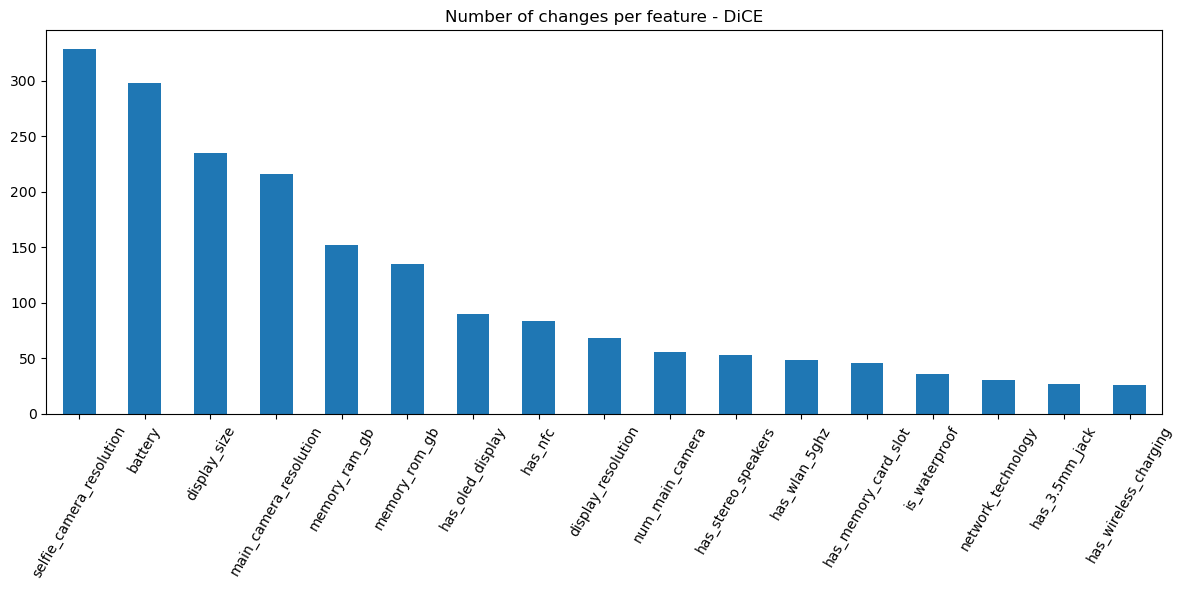

In [24]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_corr, feature_columns, plot_mode="feat_count", split_ranges=False,
    plot_title="Number of changes per feature - DiCE", figsize=(12, 6))

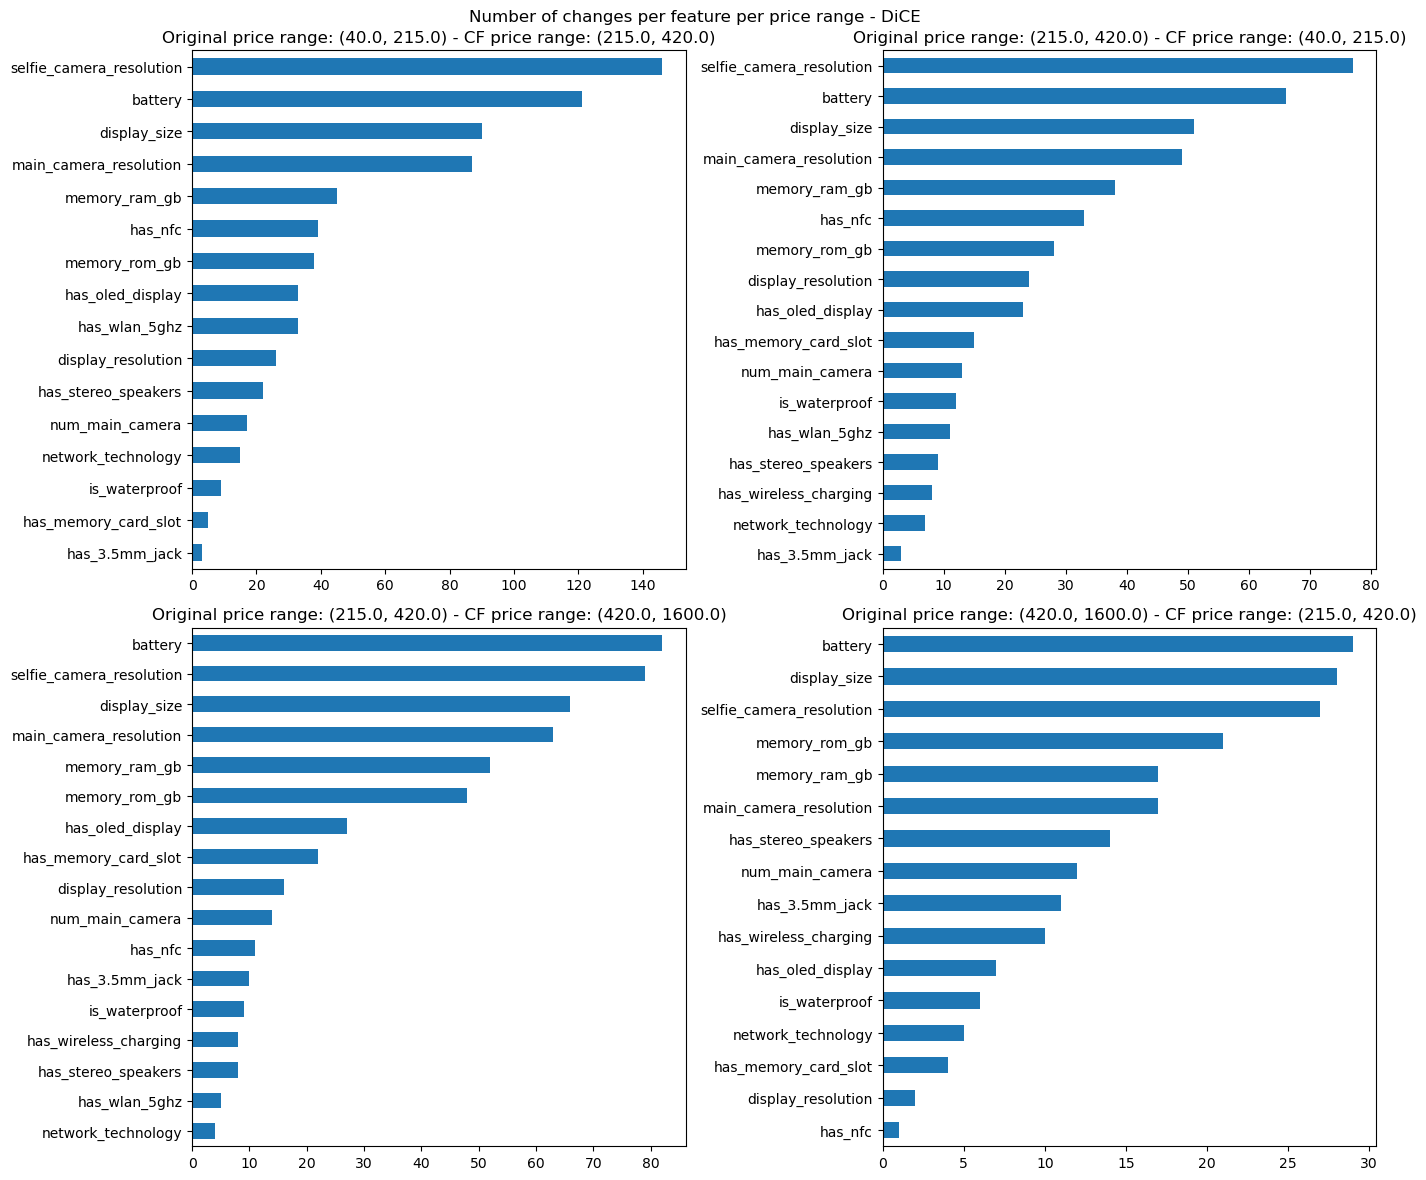

In [25]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_corr, feature_columns, plot_mode="feat_count", split_ranges=True,
    plot_title="Number of changes per feature per price range - DiCE", figsize=(14, 12)
)

### Compute closest devices to the generated counterfactuals

Another important analysis may be to examine how much the generated counterfactuals are close to existent devices.

In [26]:
def get_training_pipeline(df_train: pd.DataFrame, ordinal_encoding: dict = None, num_cols: list = None):
    df_train = df_train.copy()

    pipeline = list()
    # Ordinal pipeline
    if ordinal_encoding is not None:
        ordinal_pipeline = make_pipeline(OrdinalEncoder(categories=list(ordinal_encoding.values()), dtype=np.int64))
        ordinal_pipeline.set_output(transform="pandas")
        ordinal_columns = list(ordinal_encoding.keys())
        df_train[ordinal_columns] = ordinal_pipeline.fit_transform(df_train[ordinal_columns])
        pipeline.append((ordinal_columns, ordinal_pipeline))

    # Numerical pipeline
    if num_cols is not None:
        num_pipeline = make_pipeline(MinMaxScaler((0, 1)))
        num_pipeline.set_output(transform="pandas")
        df_train[num_cols] = num_pipeline.fit_transform(df_train[num_cols])
        pipeline.append((num_cols, num_pipeline))

    return pipeline


def apply_pipeline(pipeline: list, df: pd.DataFrame, drop_cols: list = None, rename_cols: dict = None):
    df = df.copy()
    for (cols, pipe) in pipeline:
        df[cols] = pipe.transform(df[cols])

    df = df.drop(drop_cols, axis=1)
    df = df.rename(columns=rename_cols)

    assert df.dtypes.apply(lambda x: x in [np.int64, np.float64]).all()
    return df


In [27]:
ordinal_encoding = {
    "display_resolution": ["qHD", "HD", "FHD", "QHD"],
    "network_technology": ["3G", "4G", "5G"],
    "misc_price_min": [40, 215, 420]
}
numerical_cols = df_train.columns.drop(["misc_price_min", "misc_price_max"]).to_list()

pipeline = get_training_pipeline(df_train, ordinal_encoding, numerical_cols)

In [28]:
drop_cols = ["misc_price_max"]
rename_cols = {"misc_price_min": "misc_price"}

df_train_enc = apply_pipeline(pipeline, df_train, drop_cols, rename_cols)
df_test_enc = apply_pipeline(pipeline, df_test_den, drop_cols, rename_cols)
df_dice_enc = apply_pipeline(pipeline, df_cf_dice_corr, drop_cols, rename_cols)
df_omlt_enc = apply_pipeline(pipeline, df_cf_omlt_corr, drop_cols, rename_cols)

In the following function we simply compute the most similar sample related to one cf, we can simply change the function to compute the most similar for each counterfactual, and check that the values is below a threshold.

In [29]:
def compute_most_similar_value(cf_sample: pd.Series, label: str, search_df: pd.DataFrame, same_label=False):
    '''
    A function that computes the most similar sample to the one with
    index idx present in cfs.
    '''
    X = cf_sample.drop(label)
    y = cf_sample[label]

    search_X = search_df.drop(label, axis=1)
    search_y = search_df[label]

    if same_label == True:
        search_index = search_y[search_y == y].index.difference([cf_sample.name])
    else:
        search_index = search_y.index.difference([cf_sample.name])

    if not isinstance(search_index, pd.Index):
        raise TypeError

    diff_df = (search_X.loc[search_index] - X).abs().mean(axis=1)
    # diff_df = search_X.loc[search_index].apply(lambda x: np.mean(np.abs(x - X)), axis=1)
    if not isinstance(diff_df, pd.Series):
        raise TypeError(f"norm_df is a {type(diff_df)} instead of a pd.Series")
    
    most_sim_idx = diff_df.idxmin()
    
    if diff_df.loc[most_sim_idx] > 0.1:
        print(f"WARNING: the most similar sample for the cf {cf_sample.name} has a difference greater than the threshold. The difference is {diff_df.loc[most_sim_idx]:.2f} for sample {most_sim_idx}")
        return
            
    # return search_df.loc[most_sim_idx]
    return most_sim_idx

Training similarity

In [30]:
similar_df = df_train_enc.apply(lambda x: compute_most_similar_value(x, "misc_price", df_train_enc, same_label=True), axis=1)
if not isinstance(similar_df, pd.Series):
    raise TypeError(f"similar_df is a {type(similar_df)} instead of a pd.Series")

similar_df.dropna(inplace=True)
similar_len = similar_df.shape[0]
df_len = df_train_enc.shape[0]
print(f"Number of similar samples: {similar_len} out of {df_len} ({similar_len / df_len * 100:.2f}%)")

Number of similar samples: 1500 out of 1521 (98.62%)


Test similarity

In [31]:
similar_df = df_test_enc.apply(lambda x: compute_most_similar_value(x, "misc_price", df_train_enc, same_label=True), axis=1)
if not isinstance(similar_df, pd.Series):
    raise TypeError(f"similar_df is a {type(similar_df)} instead of a pd.Series")

similar_df.dropna(inplace=True)
similar_len = similar_df.shape[0]
df_len = df_test_enc.shape[0]
print(f"Number of similar samples: {similar_len} out of {df_len} ({similar_len / df_len * 100:.2f}%)")

Number of similar samples: 382 out of 383 (99.74%)


DiCE similarity

In [32]:
similar_df = df_dice_enc.apply(lambda x: compute_most_similar_value(x, "misc_price", df_train_enc, same_label=True), axis=1)
if not isinstance(similar_df, pd.Series):
    raise TypeError(f"similar_df is a {type(similar_df)} instead of a pd.Series")

similar_df.dropna(inplace=True)
similar_len = similar_df.shape[0]
df_len = df_dice_enc.shape[0]
print(f"Number of similar samples: {similar_len} out of {df_len} ({similar_len / df_len * 100:.2f}%)")

Number of similar samples: 365 out of 372 (98.12%)


OMLT similarity

In [33]:
similar_df = df_omlt_enc.apply(lambda x: compute_most_similar_value(x, "misc_price", df_train_enc, same_label=True), axis=1)
if not isinstance(similar_df, pd.Series):
    raise TypeError(f"similar_df is a {type(similar_df)} instead of a pd.Series")

similar_df.dropna(inplace=True)
similar_len = similar_df.shape[0]
df_len = df_omlt_enc.shape[0]
print(f"Number of similar samples: {similar_len} out of {df_len} ({similar_len / df_len * 100:.2f}%)")

Number of similar samples: 333 out of 377 (88.33%)


In [34]:
idx = 314
print("The considered counterfactual is:")
samples = df_dice_enc.loc[[idx]]
display(samples)
print("The most similar is:")
most_similar_sample = samples.apply(lambda x: compute_most_similar_value(x, "misc_price", df_train_enc, same_label=True), axis=1)

for i, sim_idx in enumerate(most_similar_sample.values):
    print(f"---{sim_idx}---")
    original_sample: pd.Series = df_cf_dice_corr.loc[idx].iloc[i]
    similar_sample: pd.Series = df_train.loc[sim_idx]
    print(f"The label of the counterfactual is {original_sample.misc_price_min}-{original_sample.misc_price_max}.")
    print(f"The label of the most similar sample is {similar_sample.misc_price_min}-{similar_sample.misc_price_max}.\n")

The considered counterfactual is:


,misc_price,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,0,0.720000,0.315068,0.181818,0.111111,0.141509,0.27907,0.666667,0.5,0.333333,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
314,2,0.693333,0.236986,0.454545,0.492063,0.141509,0.44186,0.666667,0.5,0.333333,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


The most similar is:
---357---
The label of the counterfactual is 40.0-215.0.
The label of the most similar sample is 40.0-215.0.

---1203---
The label of the counterfactual is 420.0-1600.0.
The label of the most similar sample is 420.0-1600.0.



## Evaluation on misclassified samples

### OMLT

In [35]:
df_cf_omlt_mis = pd.read_csv("data/counterfactual/wrong_cf_omlt.csv", index_col=0)
df_cf_omlt_mis = util_evaluation.cast_round_type(df_cf_omlt_mis, df_test_den.dtypes.to_dict())
print(f"Number of samples in OMLT counterfactuals: {df_cf_omlt_mis.shape[0]}")
df_cf_omlt_mis.head()

Number of samples in OMLT counterfactuals: 98


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
868,215.0,420.0,5.50,4070.00,4.0,8.0,16.0,9.0,FHD,4G,1.0,0,0,1,0,1,1,0,0
771,420.0,1600.0,6.40,3750.00,6.0,128.0,19.0,26.0,FHD,4G,2.0,0,0,0,1,1,0,0,0
1672,215.0,420.0,5.50,4310.56,4.0,64.0,13.0,16.0,HD,4G,1.0,1,1,0,1,1,0,0,0
1597,40.0,215.0,5.99,4000.00,4.0,16.0,12.0,20.0,FHD,4G,2.0,0,1,0,1,1,0,0,0
1030,215.0,420.0,5.46,2868.06,4.0,64.0,12.0,20.0,FHD,4G,2.0,1,0,1,1,1,0,0,0


In [37]:
merge_df_omlt_mis = util_evaluation.join_merge_columns(df_cf_omlt_mis, df_test_den, ["misc_price_min", "misc_price_max"])

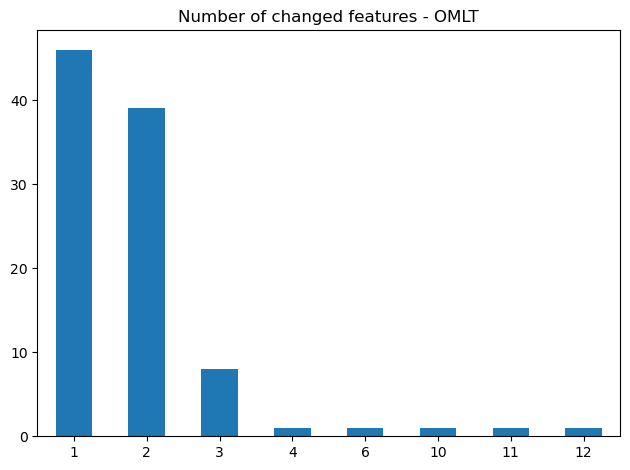

In [38]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_mis, feature_columns, plot_mode="changed_feat",
    plot_title="Number of changed features - OMLT", split_ranges=False
)

In [51]:
df_test_den.iloc[248]

misc_price_min                40.0
misc_price_max               215.0
display_size                  6.44
battery                     4850.0
memory_ram_gb                  2.0
memory_rom_gb                 16.0
main_camera_resolution        16.0
selfie_camera_resolution       5.0
display_resolution             FHD
network_technology              4G
num_main_camera                1.0
has_oled_display                 0
has_memory_card_slot             1
has_stereo_speakers              0
has_3.5mm_jack                   1
has_wlan_5ghz                    1
has_nfc                          0
has_wireless_charging            0
is_waterproof                    0
Name: 1619, dtype: object

In [44]:
merge_df_omlt_mis[(merge_df_omlt_mis["misc_price_min_cf"] == 215) & (merge_df_omlt_mis["misc_price_min_original"] == 40)]

,misc_price_min_cf,misc_price_max_cf,display_size_cf,battery_cf,memory_ram_gb_cf,memory_rom_gb_cf,main_camera_resolution_cf,selfie_camera_resolution_cf,display_resolution_cf,network_technology_cf,...,network_technology_original,num_main_camera_original,has_oled_display_original,has_memory_card_slot_original,has_stereo_speakers_original,has_3.5mm_jack_original,has_wlan_5ghz_original,has_nfc_original,has_wireless_charging_original,is_waterproof_original
248,215.0,420.0,NaN,NaN,6.0,NaN,19.0,NaN,NaN,NaN,...,4G,4.0,0,1,0,1,1,0,0,1
104,215.0,420.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,4G,3.0,0,1,0,1,1,0,0,1


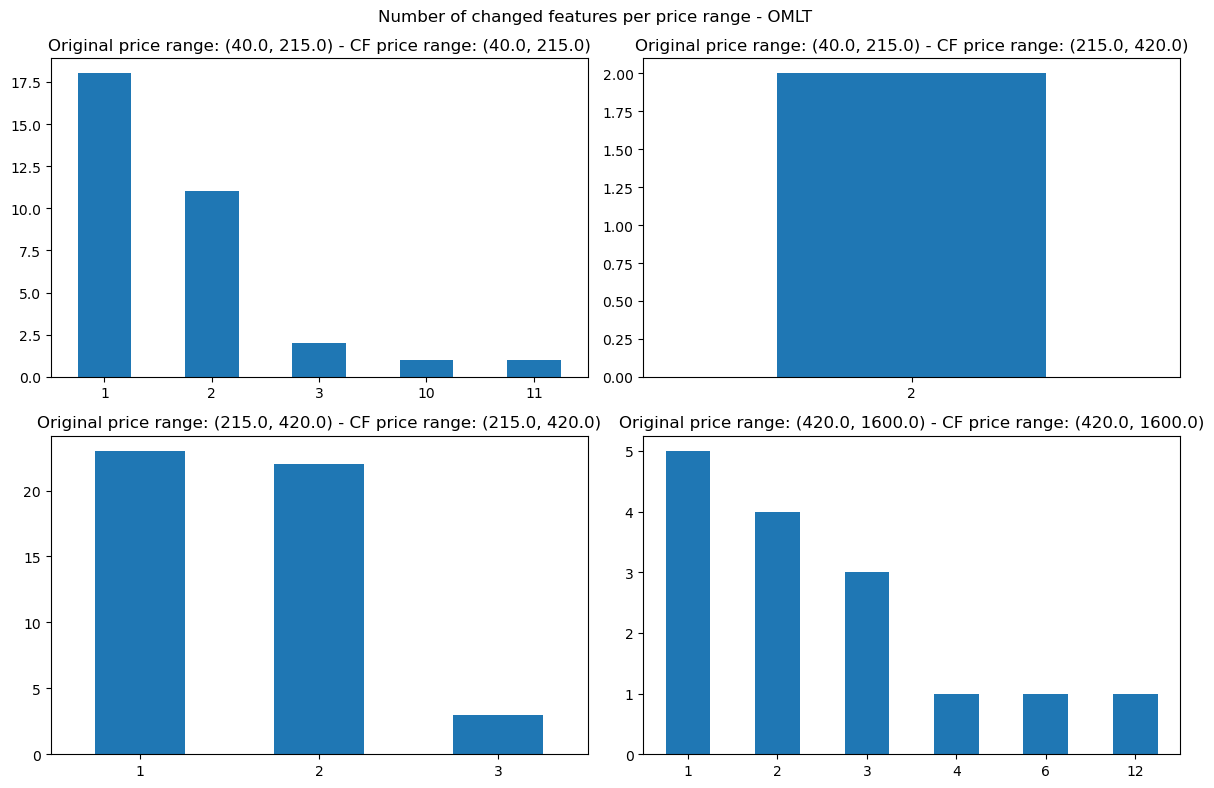

In [39]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_mis, feature_columns, plot_mode="changed_feat", split_ranges=True,
    plot_title="Number of changed features per price range - OMLT", figsize=(12, 8)
)

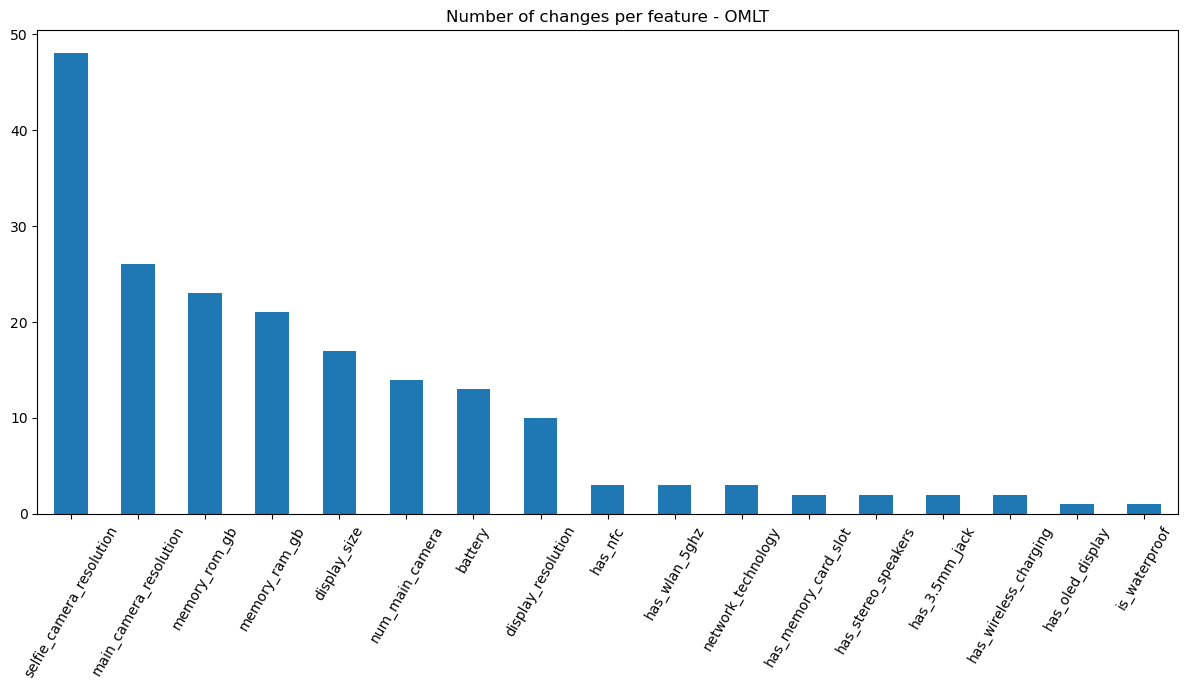

In [40]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_mis, feature_columns, plot_mode="feat_count", split_ranges=False,
    plot_title="Number of changes per feature - OMLT", figsize=(12, 7)
)

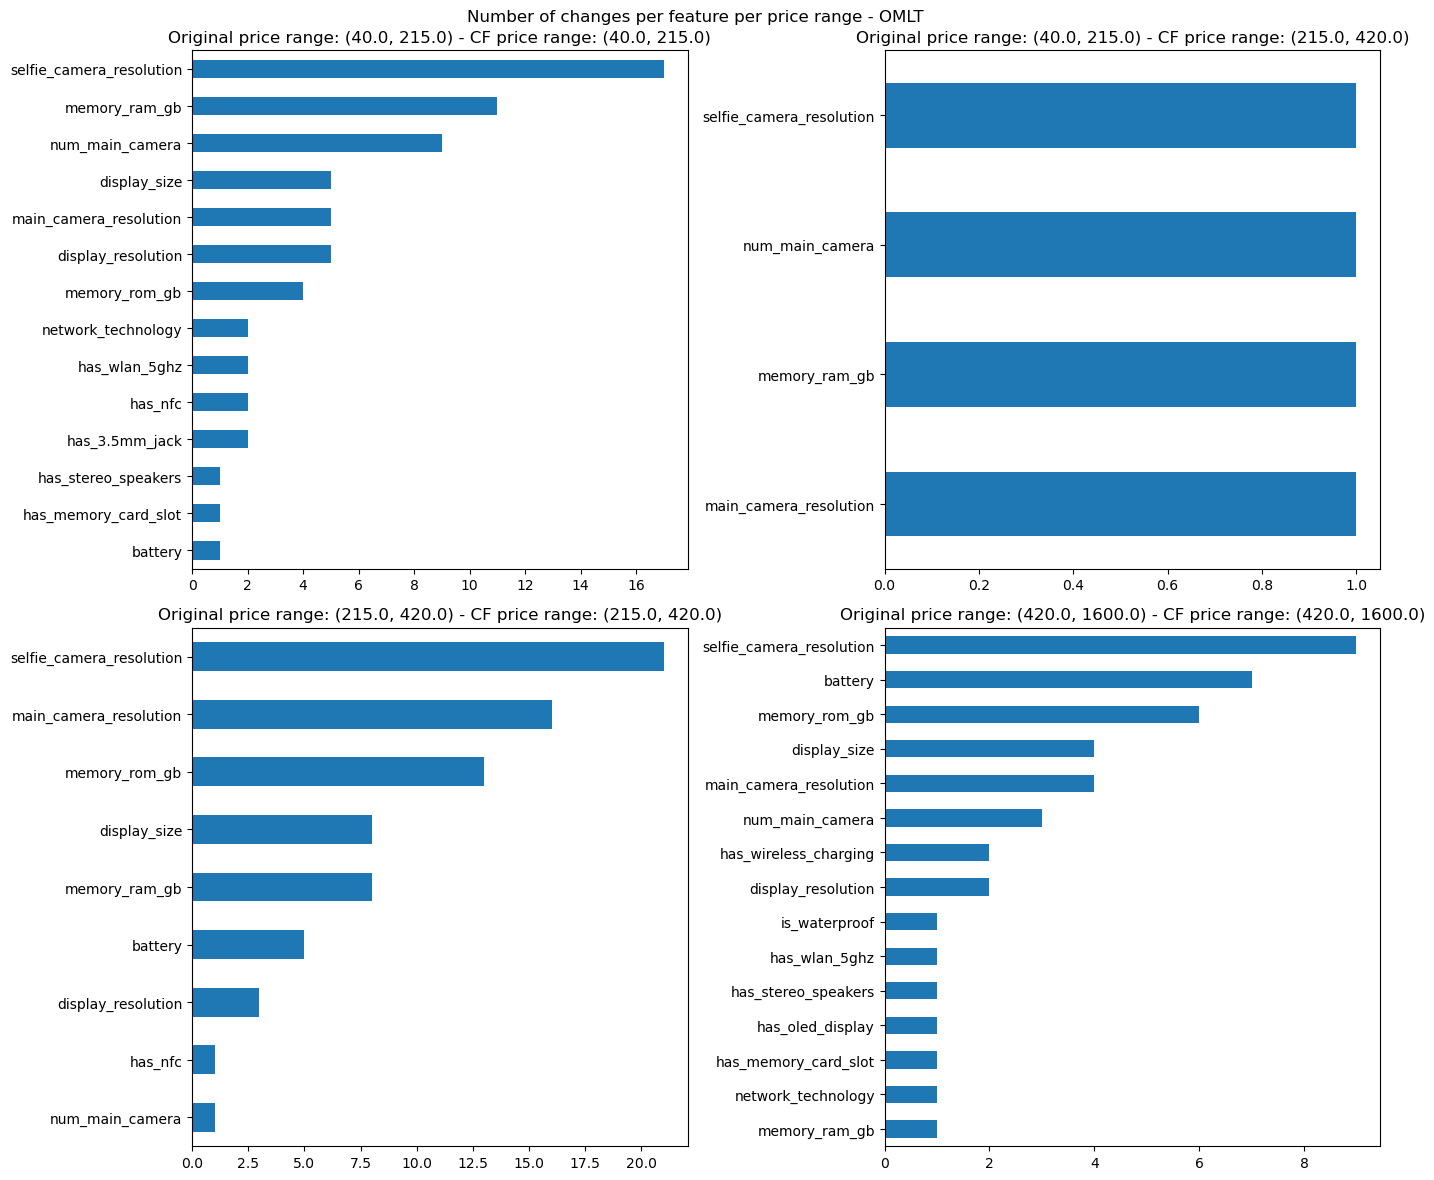

In [41]:
util_evaluation.plot_cfs_stats(
    merge_df_omlt_mis, feature_columns, plot_mode="feat_count", split_ranges=True,
    plot_title="Number of changes per feature per price range - OMLT", figsize=(14, 12)
)

### DiCE

In [45]:
df_cf_dice_mis = pd.read_csv("data/counterfactual/wrong_cf_dice.csv", index_col=0)
df_cf_dice_mis = util_evaluation.cast_round_type(df_cf_dice_mis, df_test_den.dtypes.to_dict())
print(f"Number of samples in DiCE counterfactuals: {df_cf_dice_mis.shape[0]}")
df_cf_dice_mis.head()

Number of samples in DiCE counterfactuals: 94


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
868,40.0,215.0,5.5000,3500.0000,3.0,32.0,13.0,8.0,FHD,4G,1.0,0,1,0,1,1,0,0,0
771,215.0,420.0,6.2737,3750.0000,6.0,128.0,48.0,32.0,FHD,4G,3.0,0,0,0,0,1,0,0,0
1672,40.0,215.0,5.1831,5000.0000,3.0,32.0,13.0,8.0,HD,4G,1.0,0,1,0,1,1,0,0,0
1597,215.0,420.0,6.0061,4000.0000,4.0,64.0,13.0,16.0,FHD,4G,2.0,0,1,0,1,1,0,0,0
1030,40.0,215.0,6.0061,3599.9999,4.0,64.0,12.0,8.0,FHD,4G,2.0,0,0,0,1,0,0,0,0


In [46]:
merge_df_dice_mis = util_evaluation.join_merge_columns(df_cf_dice_mis, df_test_den, ["misc_price_min", "misc_price_max"])

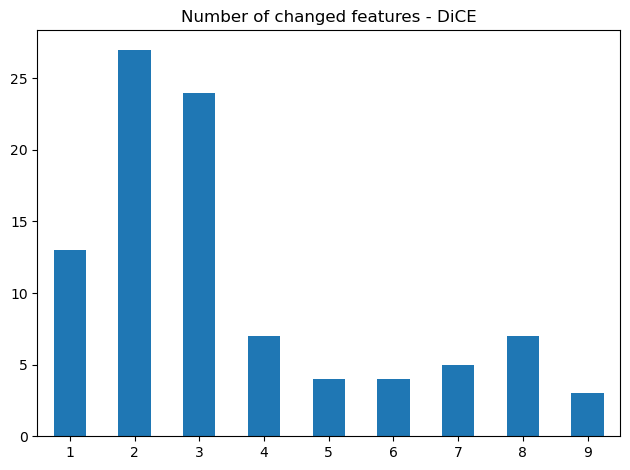

In [47]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_mis, feature_columns, plot_mode="changed_feat",
    plot_title="Number of changed features - DiCE", split_ranges=False
)

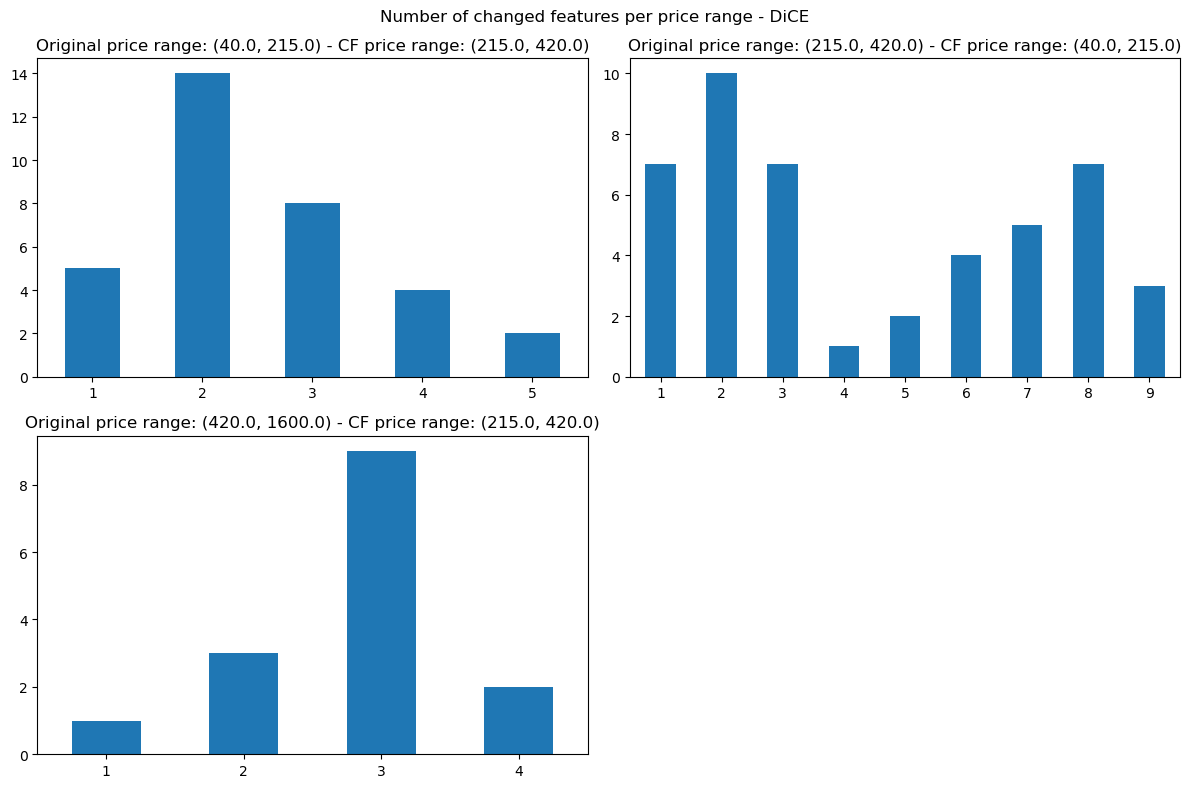

In [48]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_mis, feature_columns, plot_mode="changed_feat", split_ranges=True,
    plot_title="Number of changed features per price range - DiCE", figsize=(12, 8)
)

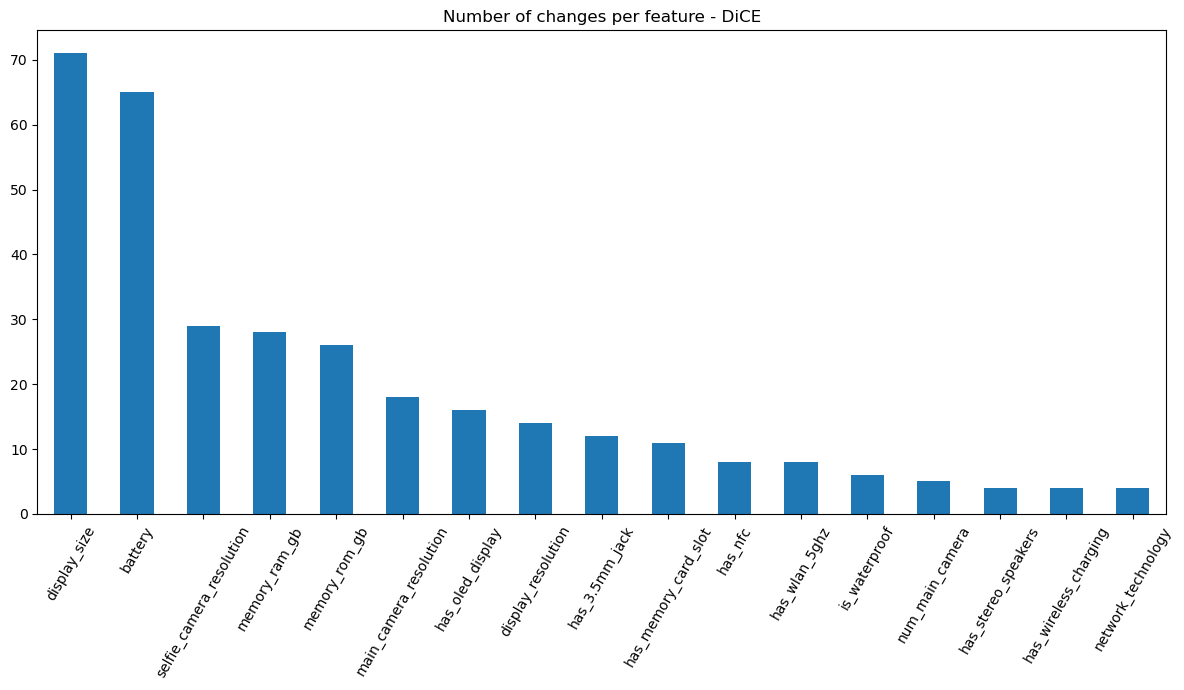

In [49]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_mis, feature_columns, plot_mode="feat_count", split_ranges=False,
    plot_title="Number of changes per feature - DiCE", figsize=(12, 7)
)

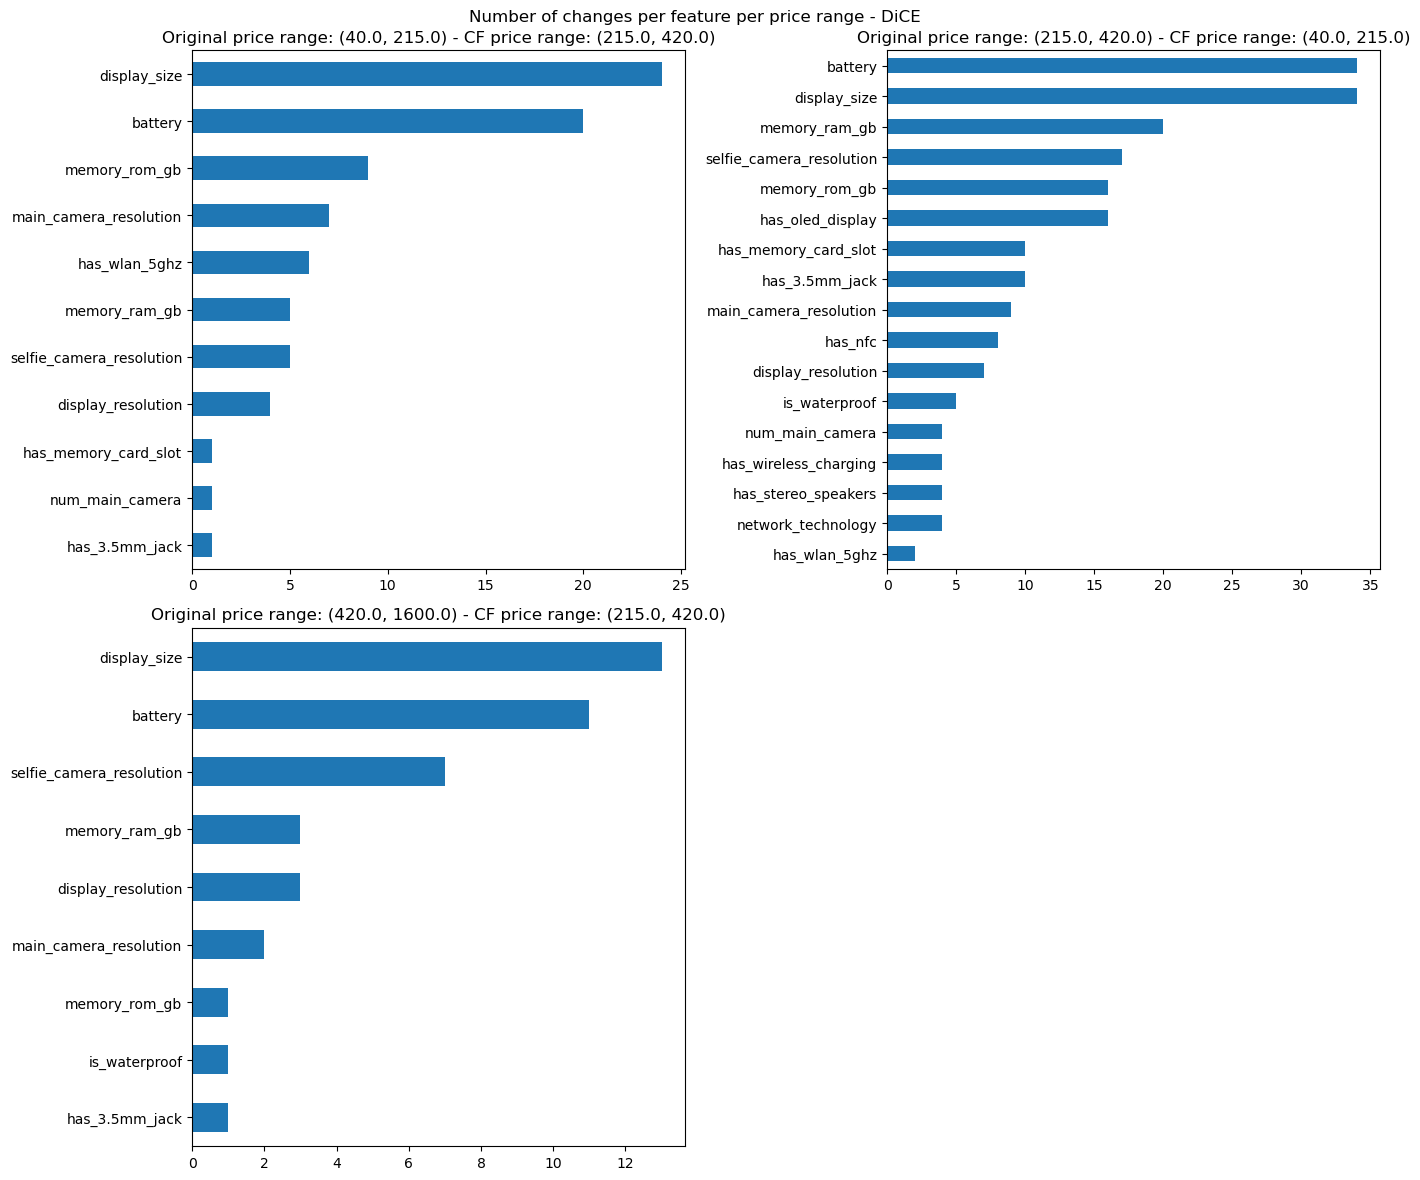

In [50]:
util_evaluation.plot_cfs_stats(
    merge_df_dice_mis, feature_columns, plot_mode="feat_count", split_ranges=True,
    plot_title="Number of changes per feature per price range - DiCE", figsize=(14, 12)
)

## Further experiments on counterfactual generation

In [202]:
from utils.util_counterfactual import generate_counterfactuals_from_sample_list
from utils import util_models

import torch

To further test the capability of our models, we decided to fix some features, such that they cannot be changed during the counterfactual generation, and we give some customized weights to the features. In the following cells we discuss the obtained results with both DiCE and OMLT.

In the following cells we import the model and the datasets that we need to perform the tests. 

In [203]:
# Import the training dataset, that we need to initialize some functions.
df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)
X_train, y_train = df_train.drop('misc_price', axis=1), df_train['misc_price']

X_test, y_test = df_test.drop('misc_price', axis=1), df_test['misc_price']

In [204]:
# Import the model
num_features = X_train.shape[1]
num_class = len(np.unique(y_train))
hidden_layers = [64, 64]
model_path = "models/nn_model.pt"

nn_model = util_models.NNClassification(hidden_layers, num_features, num_class=num_class, dropout_rate=0)

checkpoint = torch.load(model_path)
nn_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

Compute the lists of categorical and continuous features. 

In [205]:
cont_feat = [
    "display_size", "battery", "memory_ram_gb", 
    "memory_rom_gb", "main_camera_resolution", "selfie_camera_resolution"]
cat_feat = X_train.columns.drop(cont_feat).tolist()

cont_feat = [(X_train.columns.get_loc(feat), feat) for feat in cont_feat]
cat_feat = [(X_train.columns.get_loc(feat), feat) for feat in cat_feat]

print(f"Continuous features: {cont_feat}\n")
print(f"Categorical features: {cat_feat}")

Continuous features: [(0, 'display_size'), (1, 'battery'), (2, 'memory_ram_gb'), (3, 'memory_rom_gb'), (4, 'main_camera_resolution'), (5, 'selfie_camera_resolution')]

Categorical features: [(6, 'display_resolution'), (7, 'network_technology'), (8, 'num_main_camera'), (9, 'has_oled_display'), (10, 'has_memory_card_slot'), (11, 'has_stereo_speakers'), (12, 'has_3.5mm_jack'), (13, 'has_wlan_5ghz'), (14, 'has_nfc'), (15, 'has_wireless_charging'), (16, 'is_waterproof')]


Set the default values for the OMLT and DiCE options.

In [206]:
kwargs_cf_dice = {
    "target" : "misc_price",
    "n_cf" : 1,
    "verbose": False
}

solver_opt = {
    "mip display": 0,
    "timelimit": 60
}
kwargs_cf_omlt = {
    "min_probability" : 0.6, 
    "obj_weights" : [1, 1, 0.2],
    "solver": "cplex",
    "solver_options" : solver_opt,
    "verbose": False
}

### Fix some features

We know that the most changed features in DiCE are 'battery', 'display_size', 'memory_ram_gb', 'selfie_camera_resolution', 'memory_rom_gb' and 'main_camera_resolution'. In Omlt the list of features is the same and in addition there is 'display_resolution'.

For this reason it seems reasonable to fix these features in different combinations and try to understand how the model behaves.

In [207]:
features_to_fix_dice = ['battery', 'display_size', 'memory_ram_gb', 'selfie_camera_resolution', 'memory_rom_gb', 'main_camera_resolution']
features_to_fix_omlt = ["battery", "memory_ram_gb", "num_main_camera"]

weights = np.repeat(1, len(cont_feat) + len(cat_feat))
print(f"Sum of weights: {np.sum(weights)} with {len(weights)} weights.")

feature_props_dice = util_counterfactual.create_feature_props(X_train, cont_feat, cat_feat, weights, to_fix=features_to_fix_dice)
# feature_props_omlt = util_counterfactual.create_feature_props(X_train, cont_feat, cat_feat, weights, to_fix=features_to_fix_omlt)
feature_props_omlt = util_counterfactual.create_feature_props(X_train, cont_feat, cat_feat, weights)

Sum of weights: 17 with 17 weights.


Our analysis is performed on the correctly predicted samples, therefore we take some indexes from the "corr_ind" list. 

Examples: 314, 1861, 1339, 664, 918, 696

In [211]:
# idx = 314
idx = 528

sample_idx = X_test.loc[[idx]]
label_idx = y_test.loc[[idx]]

In [212]:
cfs = generate_counterfactuals_from_sample_list(
        nn_model, "dice", X_train, y_train, sample_idx, label_idx, feature_props=feature_props_dice,
        type_cf="lower", backend="PYT", target_column="misc_price", dice_method='genetic', 
        pipeline=cols_pipeline, save_filename=None, **kwargs_cf_dice
)

[0] Generating counterfactual for sample 528.


  0%|          | 0/1 [00:00<?, ?it/s]

Length of values (4563) does not match length of index (1521)
Time elapsed: 0.09700679779052734 seconds.


In [174]:
print(f"The sample to evaluate, with label {label_idx.values}, is:")
full_sample = inverse_pipeline(cols_pipeline, pd.concat([label_idx, sample_idx], axis=1))
display(full_sample)
print("\nThe generated counterfactual is:")
display(cfs)

The sample to evaluate, with label [1], is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,215.0,420.0,6.3,4050.0,4.0,64.0,26.0,13.0,FHD,4G,2.0,0,1,0,1,1,1,0,1



The generated counterfactual is:


""


Even if we tell the model not to change some features, there is a small error in the computation (~ $1e^{-4}$) but this is normal and it is as if the model kept the same value.

OMLT

In [213]:
cfs = generate_counterfactuals_from_sample_list(
    nn_model, "omlt", X_train, y_train, sample_idx, label_idx, feature_props_omlt, 
    type_cf="same", target_column="misc_price", pipeline=cols_pipeline, save_filename=None, **kwargs_cf_omlt)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[0] Generating counterfactual for sample 528.
The number of wrong values must be 1.
Time elapsed: 0.0030112266540527344 seconds.


In [216]:
print(f"The sample to evaluate, with label {label_idx.values}, is:")
full_sample = inverse_pipeline(cols_pipeline, pd.concat([label_idx, sample_idx], axis=1))
display(full_sample)
print("\nThe generated counterfactual is:")
display(cfs)

The sample to evaluate, with label [0], is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
528,40.0,215.0,5.0,2520.0,2.0,16.0,13.0,2.0,HD,4G,1.0,0,1,0,1,0,1,0,0



The generated counterfactual is:


""


### Change the weights of the features

First of all we check what is a default counterfactual generated by DiCE using the same weights for each element, then we test if increasing the weights the model doesn't change them anymore (or less).

In [187]:
# Set different weights
weights = np.repeat(1, len(cont_feat) + len(cat_feat))
# weights[X_train_val.columns.get_loc("memory_ram_gb")] = 1
weights[X_train.columns.get_loc("selfie_camera_resolution")] = 2
weights[X_train.columns.get_loc("battery")] = 2
# weights[X_train_val.columns.get_loc("main_camera_resolution")] = 1

feature_props = util_counterfactual.create_feature_props(X_train, cont_feat, cat_feat, weights)

In [188]:
cfs_w = generate_counterfactuals_from_sample_list(
        nn_model, "dice", X_train, y_train, sample_idx, label_idx, feature_props=feature_props,
        type_cf="lower", backend="PYT", target_column="misc_price", dice_method='genetic', 
        pipeline=cols_pipeline, save_filename=None, **kwargs_cf_dice
)

[0] Generating counterfactual for sample 314.


  0%|          | 0/1 [00:00<?, ?it/s]

Length of values (4563) does not match length of index (1521)
Time elapsed: 0.05498957633972168 seconds.


In [189]:
print(f"The sample to evaluate, with label {label_idx.values}, is:")
full_sample = inverse_pipeline(cols_pipeline, pd.concat([label_idx, sample_idx], axis=1))
display(full_sample)
print("\nThe counterfactual computed with the same weights is:")
display(cfs)
print("\nThe generated counterfactual with different weights is:")
display(cfs_w)

The sample to evaluate, with label [1], is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,215.0,420.0,6.3,4050.0,4.0,64.0,26.0,13.0,FHD,4G,2.0,0,1,0,1,1,1,0,1



The counterfactual computed with the same weights is:


""



The generated counterfactual with different weights is:


""


As you can see, if we increase the weights for some features the model tends to change them less.

OMLT

In [193]:
cfs = generate_counterfactuals_from_sample_list(
    nn_model, "omlt", X_train, y_train,sample_idx, label_idx, feature_props, 
    type_cf="lower", target_column="misc_price", pipeline=cols_pipeline, save_filename=None, **kwargs_cf_omlt)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[0] Generating counterfactual for sample 314.
Time elapsed: 22.720317602157593 seconds.


In [194]:
print(f"The sample to evaluate, with label {label_idx.values}, is:")
full_sample = inverse_pipeline(cols_pipeline, pd.concat([label_idx, sample_idx], axis=1))
display(full_sample)
print("\nThe generated counterfactual is:")
display(cfs)

The sample to evaluate, with label [1], is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,215.0,420.0,6.3,4050.0,4.0,64.0,26.0,13.0,FHD,4G,2.0,0,1,0,1,1,1,0,1



The generated counterfactual is:


,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.3,4050.0,1.5,64.0,19.0,13.0,FHD,4G,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
